In [5]:
from topic_specificity import calculate_specificity_for_all_topics
import pickle
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from bertopic import BERTopic

In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture
from bertopic import BERTopic


def calculate_specificity_bertopic(
    topic_model: BERTopic,
    threshold_mode: str = 'gmm',
    specificity_mode: str = 'diff'
):
    """
    Calculate specificity scores for each topic in a BERTopic model.
    Assumes `topic_model.probabilities_` is available from `fit_transform`.

    Args:
        topic_model (BERTopic): A fitted BERTopic instance.
        threshold_mode (str): 'median', 'percentile', or 'gmm'.
        specificity_mode (str): 'diff' or 'sqrt'.

    Returns:
        List[float]: Specificity score for each topic.
    """

    if topic_model.probabilities_ is None:
        raise ValueError("probabilities_ not available. Use `calculate_probabilities=True` during fit_transform.")

    probs = topic_model.probabilities_  # shape: (n_docs, n_topics)
    num_topics = probs.shape[1]
    scores = []

    for t in range(num_topics):
        weights = probs[:, t]

        # Step 1: Threshold selection
        if threshold_mode == 'median':
            bi = np.median(weights)
        elif threshold_mode == 'percentile':
            bi = np.percentile(weights, 96)
        elif threshold_mode == 'gmm':
            reshaped = weights.reshape(-1, 1)
            gmm = GaussianMixture(n_components=2).fit(reshaped)
            means = gmm.means_.flatten()
            stds = np.sqrt(gmm.covariances_).flatten()
            bi = means[0] + 2 * stds[0] if means[0] <= means[1] else means[1] + 2 * stds[1]
        else:
            raise ValueError(f"Invalid threshold_mode: {threshold_mode}")

        # Step 2: Apply threshold and compute specificity
        Di = weights[weights > bi]
        Vi = len(Di)

        if Vi == 0:
            scores.append(0.0)
            continue

        if specificity_mode == 'diff':
            myui = np.mean(Di - bi)
        elif specificity_mode == 'sqrt':
            myui = np.sqrt(np.mean((Di - bi) ** 2))
        else:
            raise ValueError(f"Invalid specificity_mode: {specificity_mode}")

        specificity = myui / (1 - bi) if (1 - bi) != 0 else 0.0
        scores.append(specificity)

    return scores


In [11]:
 # 1. Load model and corpus
dataset = '20ng'
# dictionary = pickle.load(open(f'Results/LDA/{dataset}_dictionary.dict','rb'))
# corpus = pickle.load(open(f'Results/LDA/{dataset}_corpus.pkl','rb'))
# topic_model = LdaModel.load(f"Results/LDA/{dataset}_lda50.model")

# uncomment this if using BerTopic
model_path = f'Results/BerTopic/{dataset}_bertopic_model'
topic_model = topic_model = BERTopic.load(model_path)

In [14]:
# Use this for BerTopic Model
specificity_scores = calculate_specificity_bertopic(
    topic_model,
    threshold_mode='gmm',
    specificity_mode='diff'
)
mappings = pickle.load(open(f'Results/{dataset}_repllama_bertopic_mapping.pkl','rb'))

In [13]:
# specificity_scores = calculate_specificity_for_all_topics(
#     model=topic_model,
#     corpus=corpus,
#     mode='lda',
#     threshold_mode='gmm',         # options: 'median', 'percentile', 'gmm'
#     specificity_mode='sqrt'       # options: 'diff', 'sqrt'
# )

# print("Specificity scores:", specificity_scores)
# mappings = pickle.load(open(f'Results/{dataset}_repllama_lda_mapping.pkl','rb'))

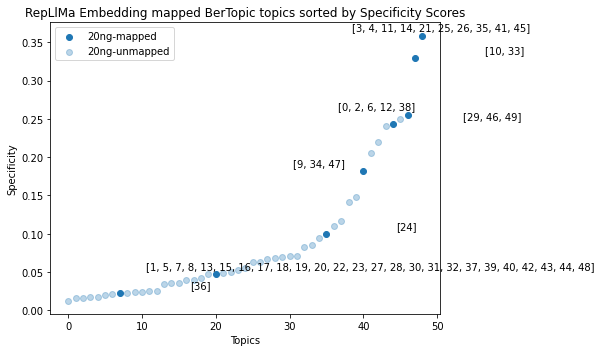

In [15]:
annotated = True
# Extract set of topics that have at least one mapped feature
mapped_topics = {topic_id for _, topic_id in mappings}

# Extract each mapped list
mapped_features = {topic_id:[feature_id for feature_id, topic in mappings if topic == topic_id] for topic_id in mapped_topics}

# Pair topic IDs with their specificity scores
topic_scores = list(enumerate(specificity_scores))

# Sort by specificity score (low to high)
sorted_topic_scores = sorted(topic_scores, key=lambda x: x[1])
sorted_topics, sorted_scores = zip(*sorted_topic_scores)

# X positions for plotting
x_positions = list(range(len(sorted_topics)))

# Split into mapped vs. unmapped
mapped_x = [x for x, t in zip(x_positions, sorted_topics) if t in mapped_topics]
mapped_y = [s for t, s in zip(sorted_topics, sorted_scores) if t in mapped_topics]

unmapped_x = [x for x, t in zip(x_positions, sorted_topics) if t not in mapped_topics]
unmapped_y = [s for t, s in zip(sorted_topics, sorted_scores) if t not in mapped_topics]

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(mapped_x, mapped_y, color='C0', alpha=1.0, label=f'{dataset}-mapped')
plt.scatter(unmapped_x, unmapped_y, color='C0', alpha=0.3, label=f'{dataset}-unmapped')
if annotated:
    # Annotate mapped features
    sorted_m_t = [t for x, t in zip(x_positions, sorted_topics) if t in mapped_topics]
    for i in range(len(sorted_m_t)):
        plt.annotate(
        str(mapped_features[sorted_m_t[i]]),              # text you want to display
        (mapped_x[i], mapped_y[i]),           # the data point coordinates
        textcoords='offset points',  # interpret xytext offset in points
        xytext=(70*(-1)**i, 5),      # shift text 5 points right and up
        ha='left'           # left-align text relative to the point
    )

plt.xlabel('Topics')
plt.ylabel('Specificity')
plt.legend()
plt.title('RepLlMa Embedding mapped BerTopic topics sorted by Specificity Scores')
plt.tight_layout()
plt.savefig(f'Results/bertopic_{dataset}_repllama.pdf')
plt.show()


## Figure with all three collections

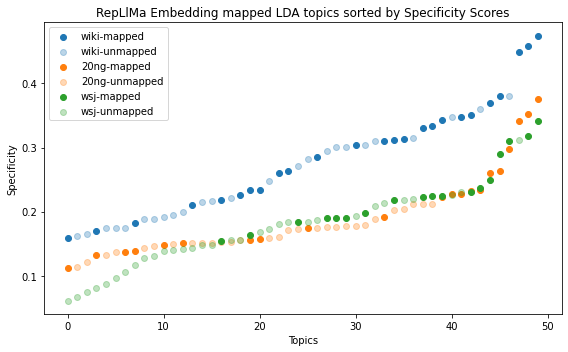

In [14]:
# Create scatter plot
plt.figure(figsize=(8, 5))
colors = ['C0','C1','C2']
i = 0
#plot for each collection
for collection in ['wiki','20ng','wsj']:
    dataset = collection
    dictionary = pickle.load(open(f'Results/LDA/{dataset}_dictionary.dict','rb'))
    corpus = pickle.load(open(f'Results/LDA/{dataset}_corpus.pkl','rb'))
    lda = LdaModel.load(f"Results/LDA/{dataset}_lda50.model")
    
    specificity_scores = calculate_specificity_for_all_topics(
        model=lda,
        corpus=corpus,
        mode='lda',
        threshold_mode='gmm',         # options: 'median', 'percentile', 'gmm'
        specificity_mode='sqrt'       # options: 'diff', 'sqrt'
    )
    
    mappings = pickle.load(open(f'Results/{dataset}_repllama_lda_mapping.pkl','rb'))
    
    # Extract set of topics that have at least one mapped feature
    mapped_topics = {topic_id for _, topic_id in mappings}

    # Extract each mapped list
    mapped_features = {topic_id:[feature_id for feature_id, topic in mappings if topic == topic_id] for topic_id in mapped_topics}

    # Pair topic IDs with their specificity scores
    topic_scores = list(enumerate(specificity_scores))

    # Sort by specificity score (low to high)
    sorted_topic_scores = sorted(topic_scores, key=lambda x: x[1])
    sorted_topics, sorted_scores = zip(*sorted_topic_scores)

    # X positions for plotting
    x_positions = list(range(len(sorted_topics)))

    # Split into mapped vs. unmapped
    mapped_x = [x for x, t in zip(x_positions, sorted_topics) if t in mapped_topics]
    mapped_y = [s for t, s in zip(sorted_topics, sorted_scores) if t in mapped_topics]

    unmapped_x = [x for x, t in zip(x_positions, sorted_topics) if t not in mapped_topics]
    unmapped_y = [s for t, s in zip(sorted_topics, sorted_scores) if t not in mapped_topics]
    
    plt.scatter(mapped_x, mapped_y, color=colors[i], alpha=1.0, label=f'{dataset}-mapped')
    plt.scatter(unmapped_x, unmapped_y, color=colors[i], alpha=0.3, label=f'{dataset}-unmapped')
    i+=1
    
plt.xlabel('Topics')
plt.ylabel('Specificity')
plt.legend()
plt.title('RepLlMa Embedding mapped LDA topics sorted by Specificity Scores')
plt.tight_layout()
plt.savefig(f'Results/lda_repllama.pdf')
plt.show()